In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
# import rapids_singlecell as rsc
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from skbio.stats.composition import clr
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries')
from data_processing import *
# main_path = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning'
# sys.path.append(main_path)

# from data_manipulation.data import Data
# from models.clustering.data_processing import *
# from models.evaluation.folds import load_existing_split

## Phenotyping

In [ ]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/hdf5_bioclavis_all_clustered_train_None_subsample_leiden_0p5.h5ad')
adata.obs

TMA     core compartment         CellX         CellY leiden_0.2  \
1        22  22-05-J      Tumour   8526.375294 -47209.294961         14   
2        22  22-05-J      Tumour   8502.780534 -47222.466136         14   
3        22  22-05-J      Tumour   8510.929662 -47224.074935         14   
4        22  22-05-J      Tumour   8517.623256 -47224.496313         14   
5        22  22-05-J      Stroma   8522.685445 -47229.076912          4   
...     ...      ...         ...           ...           ...        ...   
776711    7  07-03-E      Tumour  16055.293306 -60032.408448          2   
776712    7  07-03-E      Stroma  16074.000349 -60032.173736          2   
776713    7  07-03-E      Stroma  16094.125869 -60035.216743          3   
776714    7  07-03-E      Tumour  16043.593802 -60034.513577          2   
776715    7  07-03-E      Tumour  16192.639372 -60035.913992         12   

       leiden_0.3 leiden_0.5  
1              15         12  
2               7         27  
3               7         19  
4              15          8  
5               4          1  
...           ...        ...  
776711          1         28  
776712          1         10  
776713         12         31  
776714          1         22  
776715         19         26  

[16722665 rows x 8 columns]

In [3]:
# adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.obs['TMA'] = adata.obs['TMA'].astype('category')

In [ ]:
# sc.pp.neighbors(adata, n_neighbors=15, method='rapids', metric='euclidean', key_added='nn_leiden')
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, neighbors_key='nn_leiden', method='rapids')

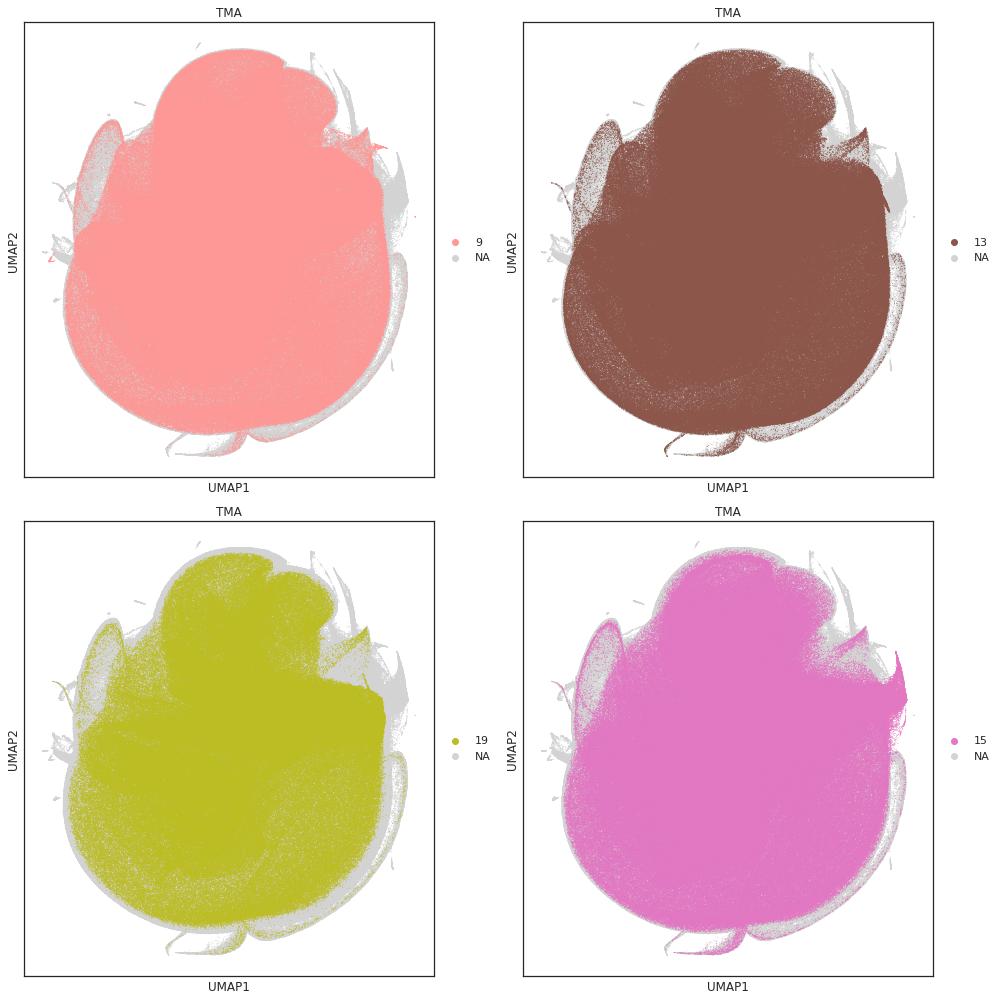

In [ ]:
# Check random 4 TMAs on a UMAP to ensure no batch effect (ie. normalisation was successful)

sns.set_theme(style="white")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
axs = axs.flatten()

random_tmas = list()

for i in range(4):
    x = random.choice(np.arange(1,23))
    random_tmas.append(x)

for i, tma in enumerate(random_tmas):
    sc.pl.umap(adata=adata, color='TMA', palette='tab20', size=3, groups=[tma], ax=axs[i], show=False)

plt.tight_layout()
plt.show()


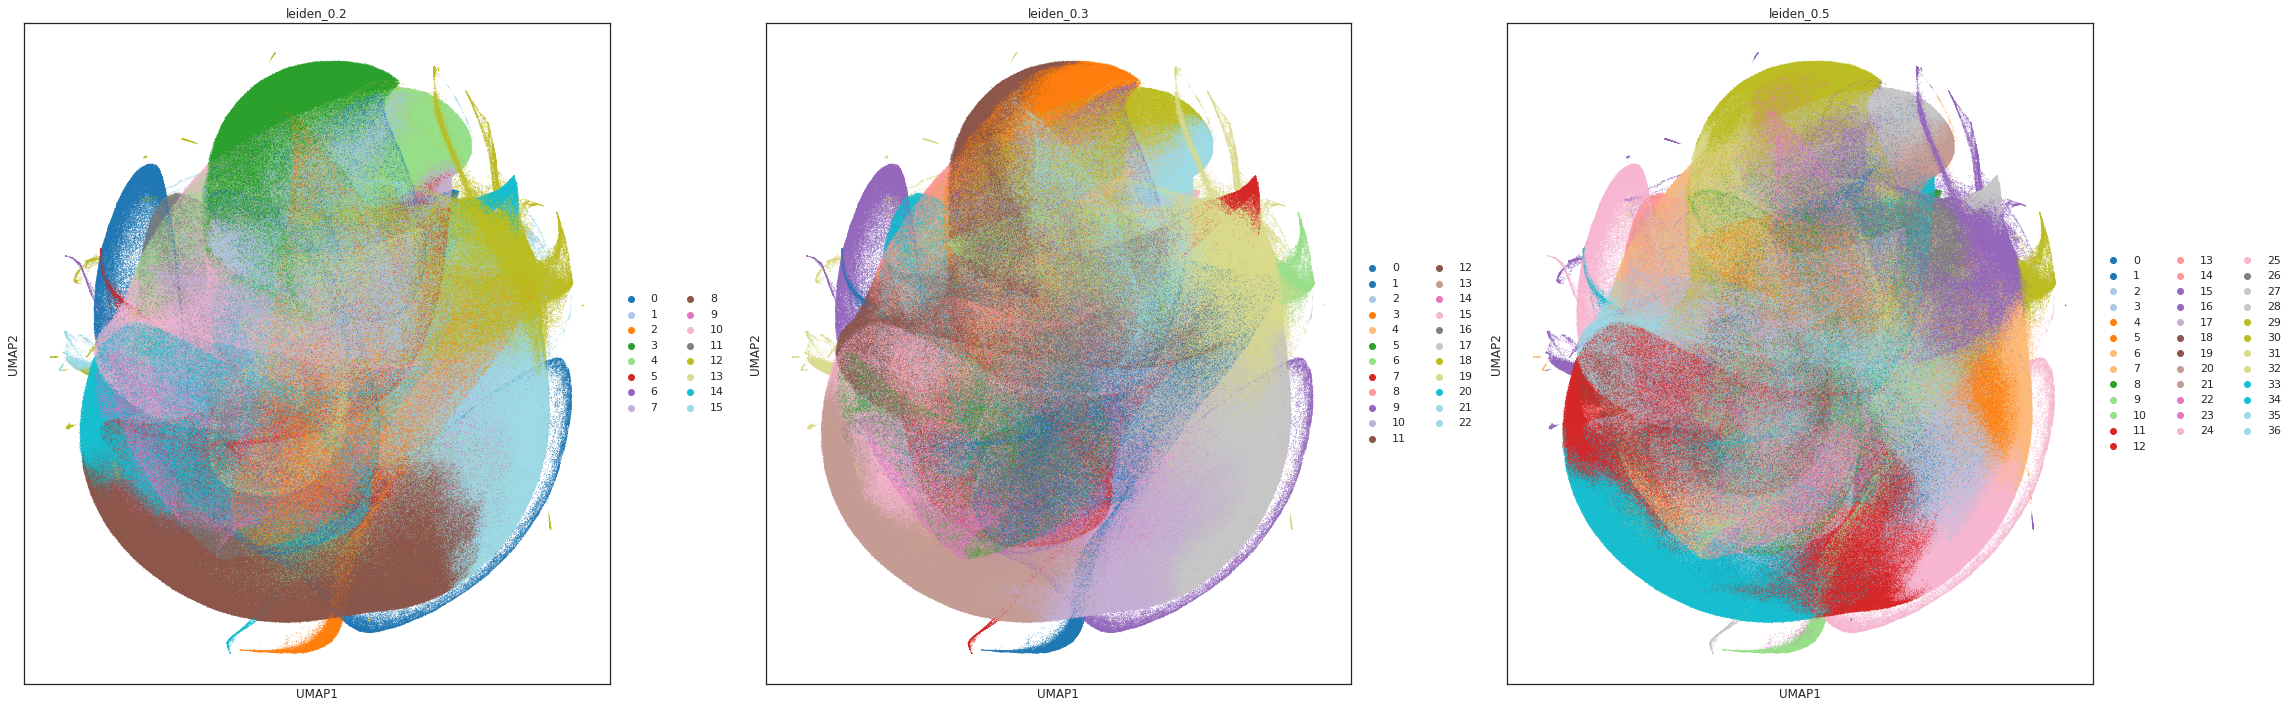

In [ ]:
resolutions = [0.2, 0.3, 0.5]


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(32,10))
axs = axs.flatten()

for i, resolution in enumerate(resolutions):
    sc.pl.umap(adata=adata, color=f'leiden_{resolution}', palette='tab20', size=2, ax=axs[i], show=False)

plt.tight_layout()
plt.show()

In [ ]:
def plot_leiden_clusters_boxplot(adata, resolution, markers, nrows, ncols):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10,nrows*8), sharey=False)
    axs = axs.flatten()

    leiden_clusters = sorted([int(cluster) for cluster in list(np.unique(adata.obs[f'leiden_{resolution}']))])

    for i, leiden in enumerate(leiden_clusters):
        subset = adata.X[adata.obs[f'leiden_{resolution}'] == str(leiden)]
        sns.boxplot(data=subset, width=0.5, ax=axs[i])
        axs[i].set_title(f'{leiden}')
        axs[i].tick_params(axis='x', labelrotation=45)
        axs[i].set_xticks(ticks=axs[i].get_xticks(), labels=markers)
        axs[i].axhline(y=0)

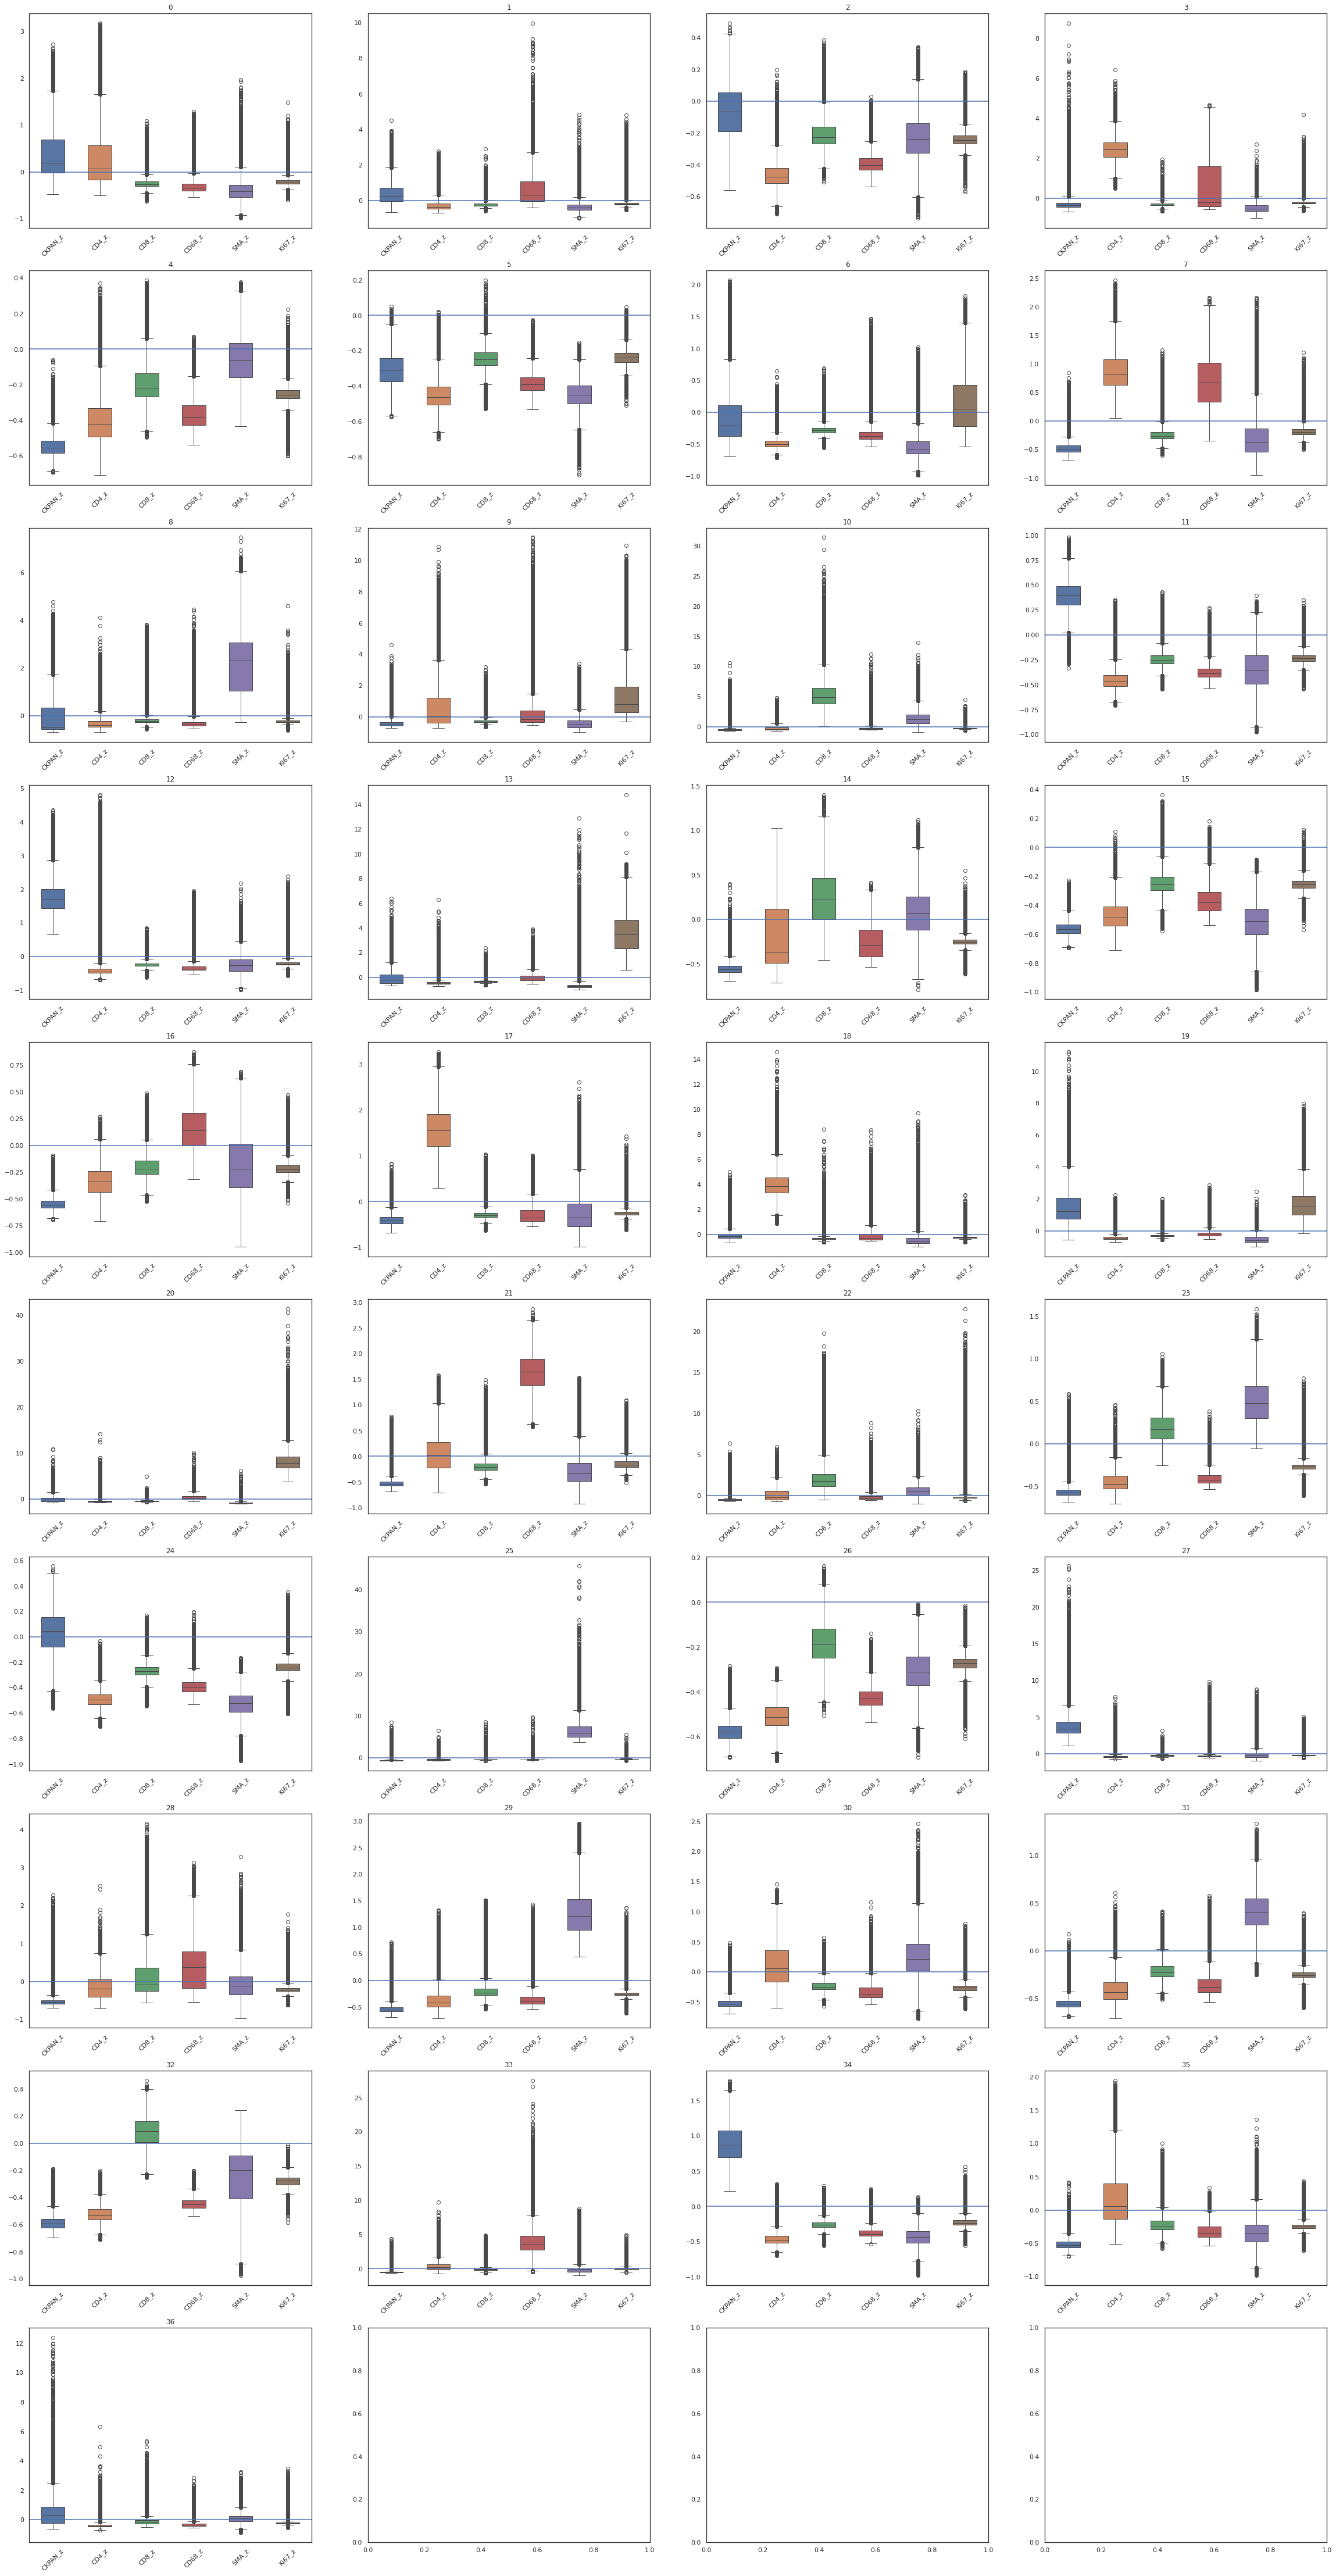

In [ ]:
res = 0.5
plot_leiden_clusters_boxplot(adata=adata, resolution=res, markers=adata.var_names, nrows=10, ncols=4)

plt.gcf()
plt.savefig(fname=f'/mnt/cephfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/TMAs/assign_bioclavis_to_clusters_post_rotation/240802_boxplot_leiden_{str(res).replace(".", "p")}.pdf', transparent=False, dpi=150, format='pdf')

In [ ]:
# adata.obs[adata.obs['TMA'] == 12][['CellX', 'CellY', 'leiden_0.5']].to_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/TMAs/assign_bioclavis_to_clusters_post_rotation/TMA_12_leiden_0p5.csv')

In [ ]:
phenotype_dictionary = {'0':'CD4+', '1':'CKPAN+', '2':'CKPAN+', '3':'CD4+', '4':'Negative', '5':'CKPAN+', '6':'CKPAN+', '7':'Negative', '8':'SMA+', '9':'CD4+',
                        '10':'CD8+', '11':'CKPAN+', '12':'CKPAN+', '13':'CKPAN+', '14':'CD8+', '15':'Negative', '16':'CD68+', '17':'CD4+', '18':'CD4+', '19':'CKPAN+',
                        '20':'CKPAN+', '21':'CD68+', '22':'CD8+', '23':'SMA+', '24':'CKPAN+', '25':'SMA+', '26':'Negative', '27':'CKPAN+', '28':'Negative', '29':'SMA+',
                        '30':'Negative', '31':'SMA+', '32':'CD8+', '33':'CD68+', '34':'CKPAN+', '35':'CD4+', '36':'CKPAN+'}

# ki67_dictionary = {'9':'Ki67+', '13':'Ki67+', '19':'Ki67+', '20':'Ki67+'}
ki67_dictionary = {'6':'1', '9':'1', '13':'1', '19':'1', '20':'1'}

adata.obs['cell_lineage'] = adata.obs['leiden_0.5'].map(phenotype_dictionary)
adata.obs['ki67_positive'] = adata.obs['leiden_0.5'].map(lambda x: ki67_dictionary.get(x, '0'))

adata.obs

TMA     core compartment         CellX         CellY leiden_0.2  \
1       22  22-05-J      Tumour   8526.375294 -47209.294961         14   
2       22  22-05-J      Tumour   8502.780534 -47222.466136         14   
3       22  22-05-J      Tumour   8510.929662 -47224.074935         14   
4       22  22-05-J      Tumour   8517.623256 -47224.496313         14   
5       22  22-05-J      Stroma   8522.685445 -47229.076912          4   
...     ..      ...         ...           ...           ...        ...   
776711   7  07-03-E      Tumour  16055.293306 -60032.408448          2   
776712   7  07-03-E      Stroma  16074.000349 -60032.173736          2   
776713   7  07-03-E      Stroma  16094.125869 -60035.216743          3   
776714   7  07-03-E      Tumour  16043.593802 -60034.513577          2   
776715   7  07-03-E      Tumour  16192.639372 -60035.913992         12   

       leiden_0.3 leiden_0.5 cell_lineage ki67_positive  
1              15         12       CKPAN+             0  
2               7         27       CKPAN+             0  
3               7         19       CKPAN+             1  
4              15          8         SMA+             0  
5               4          1       CKPAN+             0  
...           ...        ...          ...           ...  
776711          1         28     Negative             0  
776712          1         10         CD8+             0  
776713         12         31         SMA+             0  
776714          1         22         CD8+             0  
776715         19         26     Negative             0  

[16722665 rows x 10 columns]

In [ ]:
adata.obs['cell_lineage'].value_counts()

CKPAN+      5898706
Negative    3505130
CD4+        2740986
SMA+        2023265
CD8+        1283500
CD68+       1271078
Name: cell_lineage, dtype: int64

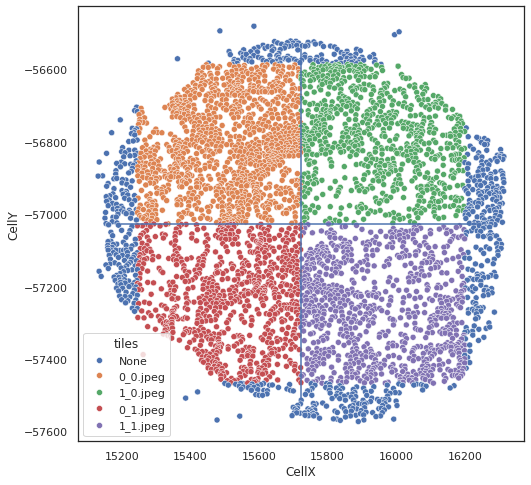

In [ ]:
# Subsetting a single core to demonstrate cell-to-tile assignment graphically
# Need to scale to each core in turn to ensure min-max scaling works

from sklearn.preprocessing import MinMaxScaler

diam = 403.2
height = (diam) / 1000

core_01_02_D = adata.obs[adata.obs['core'] == '01-02-D']

upper_x, lower_x = core_01_02_D['CellX'].max(), core_01_02_D['CellX'].min()
upper_y, lower_y = core_01_02_D['CellY'].max(), core_01_02_D['CellY'].min()

scaler = MinMaxScaler()

scaled_x = scaler.fit_transform(core_01_02_D['CellX'].values.reshape(-1,1))
core_01_02_D['CellX_norm'] = scaled_x

scaled_y = scaler.fit_transform(core_01_02_D['CellY'].values.reshape(-1,1))
core_01_02_D['CellY_norm'] = scaled_y

core_centroid_x = ((core_01_02_D['CellX'].max() - core_01_02_D['CellX'].min()) // 2) + core_01_02_D['CellX'].min()
core_centroid_y = ((core_01_02_D['CellY'].max() - core_01_02_D['CellY'].min()) // 2) + core_01_02_D['CellY'].min()

ymax = 0.5 + height
ymin = 0.5 - height
xmax = 0.5 + height
xmin = 0.5 - height

for i, row in core_01_02_D.iterrows():
    if xmin < row['CellX_norm'] < 0.5 and 0.5 < row['CellY_norm'] < ymax:
        core_01_02_D.loc[i, 'tiles'] = '0_0.jpeg'
    elif 0.5 < row['CellX_norm'] < xmax and 0.5 < row['CellY_norm'] < ymax:
        core_01_02_D.loc[i, 'tiles'] = '1_0.jpeg'
    elif xmin < row['CellX_norm'] < 0.5 and ymin < row['CellY_norm'] < 0.5:
        core_01_02_D.loc[i, 'tiles'] = '0_1.jpeg'
    elif 0.5 < row['CellX_norm'] < xmax and ymin < row['CellY_norm'] < 0.5:
        core_01_02_D.loc[i, 'tiles'] = '1_1.jpeg'
    else:
        core_01_02_D.loc[i, 'tiles'] = 'None'

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=core_01_02_D, x='CellX', y='CellY', hue='tiles', ax=ax)

ax.axvline(x=core_centroid_x, ymin=0.5 - height, ymax=0.5 + height)
ax.axhline(y=core_centroid_y, xmin=0.5 - height, xmax=0.5 + height)

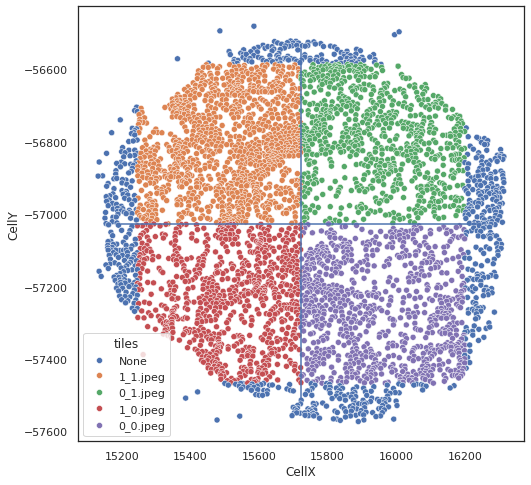

In [ ]:
## The mIF tiles are rotated by 180deg compared to the H&Es that went through HPL
## Therefore we need to rotate the tile assignation by 180deg
## The orientation of the tiles is unimportant since we are just drawing lines around a group of cells 

diam = 403.2
height = (diam) / 1000

core_01_02_D = adata.obs[adata.obs['core'] == '01-02-D']

upper_x, lower_x = core_01_02_D['CellX'].max(), core_01_02_D['CellX'].min()
upper_y, lower_y = core_01_02_D['CellY'].max(), core_01_02_D['CellY'].min()

scaler = MinMaxScaler()

scaled_x = scaler.fit_transform(core_01_02_D['CellX'].values.reshape(-1,1))
core_01_02_D['CellX_norm'] = scaled_x

scaled_y = scaler.fit_transform(core_01_02_D['CellY'].values.reshape(-1,1))
core_01_02_D['CellY_norm'] = scaled_y

core_centroid_x = ((core_01_02_D['CellX'].max() - core_01_02_D['CellX'].min()) // 2) + core_01_02_D['CellX'].min()
core_centroid_y = ((core_01_02_D['CellY'].max() - core_01_02_D['CellY'].min()) // 2) + core_01_02_D['CellY'].min()

ymax = 0.5 + height
ymin = 0.5 - height
xmax = 0.5 + height
xmin = 0.5 - height

for i, row in core_01_02_D.iterrows():
    if xmin < row['CellX_norm'] < 0.5 and 0.5 < row['CellY_norm'] < ymax:
        core_01_02_D.loc[i, 'tiles'] = '1_1.jpeg'
    elif 0.5 < row['CellX_norm'] < xmax and 0.5 < row['CellY_norm'] < ymax:
        core_01_02_D.loc[i, 'tiles'] = '0_1.jpeg'
    elif xmin < row['CellX_norm'] < 0.5 and ymin < row['CellY_norm'] < 0.5:
        core_01_02_D.loc[i, 'tiles'] = '1_0.jpeg'
    elif 0.5 < row['CellX_norm'] < xmax and ymin < row['CellY_norm'] < 0.5:
        core_01_02_D.loc[i, 'tiles'] = '0_0.jpeg'
    else:
        core_01_02_D.loc[i, 'tiles'] = 'None'

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=core_01_02_D, x='CellX', y='CellY', hue='tiles', ax=ax)

ax.axvline(x=core_centroid_x, ymin=0.5 - height, ymax=0.5 + height)
ax.axhline(y=core_centroid_y, xmin=0.5 - height, xmax=0.5 + height)

In [ ]:
## Apply tile assignment to the whole dataset, needs each core to be done in turn as these are separate images with their own coordinates

for core in adata.obs['core'].unique():
    core_mask = adata.obs['core'] == core
    
    upper_x, lower_x = adata.obs[core_mask]['CellX'].max(), adata.obs[core_mask]['CellX'].min()
    upper_y, lower_y = adata.obs[core_mask]['CellY'].max(), adata.obs[core_mask]['CellY'].min()
    
    scaler = MinMaxScaler()

    scaled_x = scaler.fit_transform(adata.obs[core_mask]['CellX'].values.reshape(-1,1))
    adata.obs.loc[core_mask, 'CellX_norm'] = scaled_x

    scaled_y = scaler.fit_transform(adata.obs[core_mask]['CellY'].values.reshape(-1,1))
    adata.obs.loc[core_mask, 'CellY_norm'] = scaled_y

adata.obs

TMA     core compartment         CellX         CellY leiden_0.2  \
1       22  22-05-J      Tumour   8526.375294 -47209.294961         14   
2       22  22-05-J      Tumour   8502.780534 -47222.466136         14   
3       22  22-05-J      Tumour   8510.929662 -47224.074935         14   
4       22  22-05-J      Tumour   8517.623256 -47224.496313         14   
5       22  22-05-J      Stroma   8522.685445 -47229.076912          4   
...     ..      ...         ...           ...           ...        ...   
776711   7  07-03-E      Tumour  16055.293306 -60032.408448          2   
776712   7  07-03-E      Stroma  16074.000349 -60032.173736          2   
776713   7  07-03-E      Stroma  16094.125869 -60035.216743          3   
776714   7  07-03-E      Tumour  16043.593802 -60034.513577          2   
776715   7  07-03-E      Tumour  16192.639372 -60035.913992         12   

       leiden_0.3 leiden_0.5 cell_lineage ki67_positive  CellX_norm  \
1              15         12       CKPAN+             0    0.173370   
2               7         27       CKPAN+             0    0.153310   
3               7         19       CKPAN+             1    0.160238   
4              15          8         SMA+             0    0.165929   
5               4          1       CKPAN+             0    0.170233   
...           ...        ...          ...           ...         ...   
776711          1         28     Negative             0    0.373812   
776712          1         10         CD8+             0    0.389847   
776713         12         31         SMA+             0    0.407098   
776714          1         22         CD8+             0    0.363783   
776715         19         26     Negative             0    0.491541   

        CellY_norm  
1         0.882575  
2         0.870625  
3         0.869166  
4         0.868783  
5         0.864628  
...            ...  
776711    0.013363  
776712    0.013566  
776713    0.010939  
776714    0.011546  
776715    0.010337  

[16722665 rows x 12 columns]

In [ ]:
## The diameter of a 5x tile used for HPL in our model in microns
## The mask variables are named in relation to their position on the mIF image to avoid confusion
## The corresponding tile coordinates do not obviously match to this, but rather match the position on the corresponding H&E image that was used for HPL

diam=403.2
height = (diam) / 1000

ymax = 0.5 + height
ymin = 0.5 - height
xmax = 0.5 + height
xmin = 0.5 - height

upper_left  = (adata.obs['CellX_norm'] > xmin) & (adata.obs['CellX_norm'] < 0.5) & (adata.obs['CellY_norm'] > 0.5) & (adata.obs['CellY_norm'] < ymax)
upper_right = (adata.obs['CellX_norm'] > 0.5) & (adata.obs['CellX_norm'] < xmax) & (adata.obs['CellY_norm'] > 0.5) & (adata.obs['CellY_norm'] < ymax)
lower_left  = (adata.obs['CellX_norm'] > xmin) & (adata.obs['CellX_norm'] < 0.5) & (adata.obs['CellY_norm'] > ymin) & (adata.obs['CellY_norm'] < 0.5)
lower_right = (adata.obs['CellX_norm'] > 0.5) & (adata.obs['CellX_norm'] < xmax) & (adata.obs['CellY_norm'] > ymin) & (adata.obs['CellY_norm'] < 0.5)

adata.obs.loc[:, 'tiles'] = 'None'

adata.obs.loc[upper_left, 'tiles'] = '1_1.jpeg'
adata.obs.loc[upper_right, 'tiles'] = '0_1.jpeg'
adata.obs.loc[lower_left, 'tiles'] = '1_0.jpeg'
adata.obs.loc[lower_right, 'tiles'] = '0_0.jpeg'

adata.obs

TMA     core compartment         CellX         CellY leiden_0.2  \
1       22  22-05-J      Tumour   8526.375294 -47209.294961         14   
2       22  22-05-J      Tumour   8502.780534 -47222.466136         14   
3       22  22-05-J      Tumour   8510.929662 -47224.074935         14   
4       22  22-05-J      Tumour   8517.623256 -47224.496313         14   
5       22  22-05-J      Stroma   8522.685445 -47229.076912          4   
...     ..      ...         ...           ...           ...        ...   
776711   7  07-03-E      Tumour  16055.293306 -60032.408448          2   
776712   7  07-03-E      Stroma  16074.000349 -60032.173736          2   
776713   7  07-03-E      Stroma  16094.125869 -60035.216743          3   
776714   7  07-03-E      Tumour  16043.593802 -60034.513577          2   
776715   7  07-03-E      Tumour  16192.639372 -60035.913992         12   

       leiden_0.3 leiden_0.5 cell_lineage ki67_positive  CellX_norm  \
1              15         12       CKPAN+             0    0.173370   
2               7         27       CKPAN+             0    0.153310   
3               7         19       CKPAN+             1    0.160238   
4              15          8         SMA+             0    0.165929   
5               4          1       CKPAN+             0    0.170233   
...           ...        ...          ...           ...         ...   
776711          1         28     Negative             0    0.373812   
776712          1         10         CD8+             0    0.389847   
776713         12         31         SMA+             0    0.407098   
776714          1         22         CD8+             0    0.363783   
776715         19         26     Negative             0    0.491541   

        CellY_norm     tiles  
1         0.882575  1_1.jpeg  
2         0.870625  1_1.jpeg  
3         0.869166  1_1.jpeg  
4         0.868783  1_1.jpeg  
5         0.864628  1_1.jpeg  
...            ...       ...  
776711    0.013363      None  
776712    0.013566      None  
776713    0.010939      None  
776714    0.011546      None  
776715    0.010337      None  

[16722665 rows x 13 columns]

In [ ]:
# Backup the h5ad file after clustering and phenotype assignment
adata.write_h5ad('/mnt/cephfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/TMAs/assign_bioclavis_to_clusters_post_rotation/240805_Bioclavis_clustered_phenotypes.h5ad')

## Downstream analysis

In [5]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/240805_Bioclavis_clustered_phenotypes.h5ad')

In [ ]:
adata = adata[adata.obs['cell_lineage'] != 'Negative']

In [ ]:
rsc.pp.neighbors(adata, n_neighbors=15, metric='euclidean', key_added='nn_leiden')
rsc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, neighbors_key='nn_leiden')

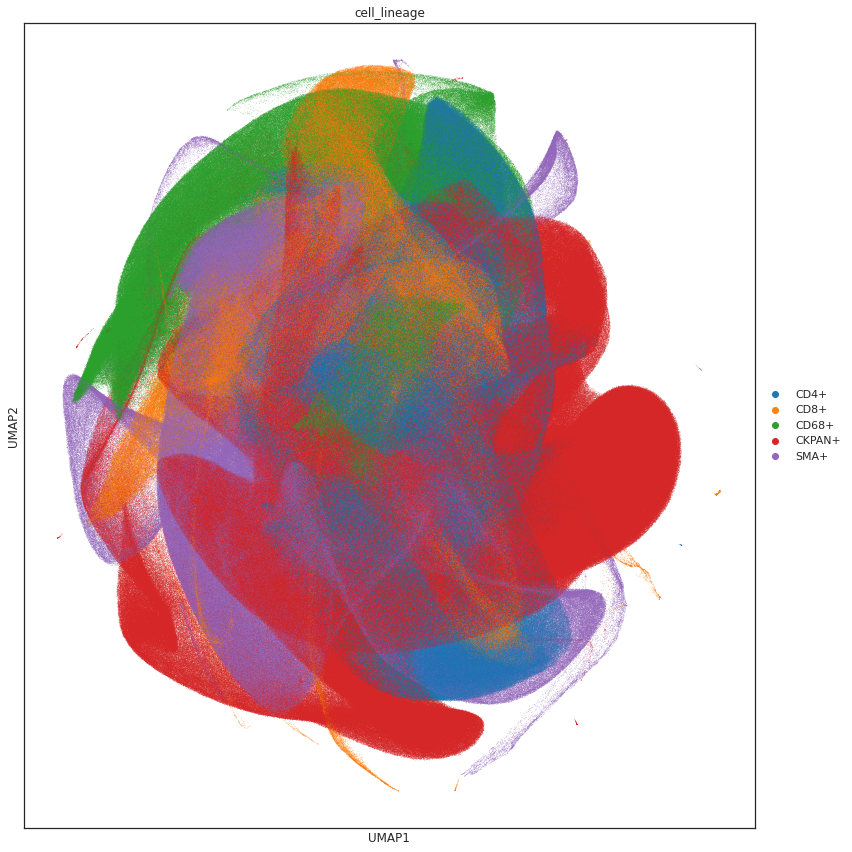

In [ ]:
sns.set_theme(style="white")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
sc.pl.umap(adata, show=False, color='cell_lineage', ax=ax, s=0.8)

plt.gcf()
plt.tight_layout()
plt.show()

In [ ]:
## Import leiden clusters from H&Es

clusters_frame = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/adatas/LATTICeA_BioclavisHE_4pc_5x_he_train_filtered_leiden_2p5__fold2.csv')
leiden_clusters = np.unique(clusters_frame['leiden_2.5'])

leiden_clusters, malignant_clusters, stromal_clusters = load_topography()

clusters_frame['core'] = clusters_frame['slides'].apply(lambda x: x[9:])
clusters_frame = clusters_frame[['samples', 'slides', 'tiles', 'leiden_2.5', 'core']]
clusters_frame

samples            slides     tiles  leiden_2.5     core
0     ACA_0224  ACA_0224_04-07-H  0_1.jpeg          21  04-07-H
1     ACA_0224  ACA_0224_04-07-H  1_0.jpeg          50  04-07-H
2     ACA_0224  ACA_0224_04-07-H  0_0.jpeg          64  04-07-H
3     ACA_0224  ACA_0224_04-07-H  1_1.jpeg          21  04-07-H
4     ACA_0224  ACA_0224_04-06-H  0_1.jpeg          54  04-06-H
...        ...               ...       ...         ...      ...
8370  ACA_0347  ACA_0347_04-16-C  1_1.jpeg          12  04-16-C
8371  ACA_0896  ACA_0896_18-04-I  0_1.jpeg          33  18-04-I
8372  ACA_0896  ACA_0896_18-04-I  1_0.jpeg          33  18-04-I
8373  ACA_0896  ACA_0896_18-04-I  0_0.jpeg          33  18-04-I
8374  ACA_0896  ACA_0896_18-04-I  1_1.jpeg          17  18-04-I

[8375 rows x 5 columns]

In [7]:
## Merge the leiden clusters data into the annotated data matrix
## Filter the cores which do not have corresponding leiden clusters

adata.obs = adata.obs.merge(clusters_frame[['core', 'samples', 'tiles', 'leiden_2.5']], on=['core', 'tiles'], how='left')
adata.obs

TMA     core compartment         CellX         CellY leiden_0.2  \
0         22  22-05-J      Tumour   8526.375294 -47209.294961         14   
1         22  22-05-J      Tumour   8502.780534 -47222.466136         14   
2         22  22-05-J      Tumour   8510.929662 -47224.074935         14   
3         22  22-05-J      Tumour   8517.623256 -47224.496313         14   
4         22  22-05-J      Stroma   8522.685445 -47229.076912          4   
...       ..      ...         ...           ...           ...        ...   
16722660   7  07-03-E      Tumour  16055.293306 -60032.408448          2   
16722661   7  07-03-E      Stroma  16074.000349 -60032.173736          2   
16722662   7  07-03-E      Stroma  16094.125869 -60035.216743          3   
16722663   7  07-03-E      Tumour  16043.593802 -60034.513577          2   
16722664   7  07-03-E      Tumour  16192.639372 -60035.913992         12   

         leiden_0.3 leiden_0.5 cell_lineage ki67_positive  CellX_norm  \
0                15         12       CKPAN+             0    0.173370   
1                 7         27       CKPAN+             0    0.153310   
2                 7         19       CKPAN+             1    0.160238   
3                15          8         SMA+             0    0.165929   
4                 4          1       CKPAN+             0    0.170233   
...             ...        ...          ...           ...         ...   
16722660          1         28     Negative             0    0.373812   
16722661          1         10         CD8+             0    0.389847   
16722662         12         31         SMA+             0    0.407098   
16722663          1         22         CD8+             0    0.363783   
16722664         19         26     Negative             0    0.491541   

          CellY_norm     tiles   samples  leiden_2.5  
0           0.882575  1_1.jpeg  ACA_1067        46.0  
1           0.870625  1_1.jpeg  ACA_1067        46.0  
2           0.869166  1_1.jpeg  ACA_1067        46.0  
3           0.868783  1_1.jpeg  ACA_1067        46.0  
4           0.864628  1_1.jpeg  ACA_1067        46.0  
...              ...       ...       ...         ...  
16722660    0.013363      None       NaN         NaN  
16722661    0.013566      None       NaN         NaN  
16722662    0.010939      None       NaN         NaN  
16722663    0.011546      None       NaN         NaN  
16722664    0.010337      None       NaN         NaN  

[16722665 rows x 15 columns]

In [8]:
adata.var_names = [c.split("_")[0] for c in adata.var_names]

[Text(0, 0.5, 'Tumour'),
 Text(0, 1.5, 'CD8+ T-cells'),
 Text(0, 2.5, 'SMA+ cells'),
 Text(0, 3.5, 'CD4+ T-cells'),
 Text(0, 4.5, 'CD68+ Macrophages')]

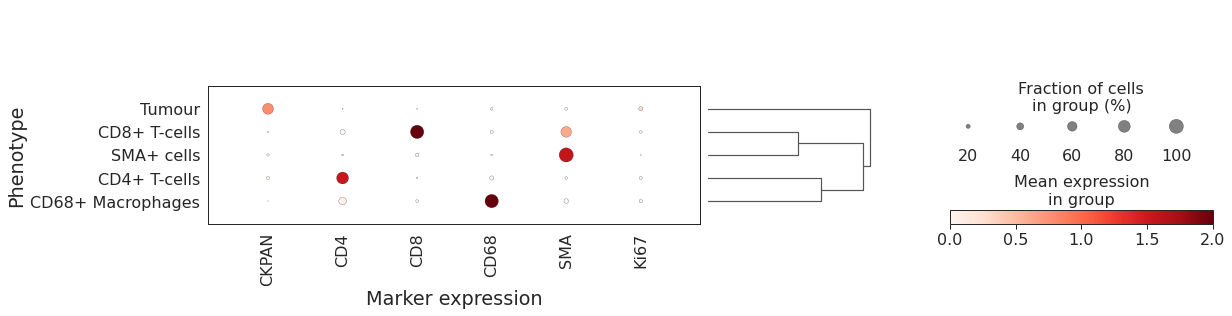

In [ ]:
sns.set_context("paper", font_scale=2.0)

sc.tl.dendrogram(adata=adata, groupby='cell_lineage')
fig, ax = plt.subplots(figsize=(18,4))

dp = sc.pl.dotplot(adata, var_names=adata.var_names, groupby="cell_lineage", dendrogram=True, ax=ax, vmin=0, vmax=2, dot_min=0, dot_max=1, return_fig=True)
axes_dict = dp.get_axes()
axes_dict['mainplot_ax'].set_xlabel('Marker expression')
axes_dict['mainplot_ax'].set_ylabel('Phenotype')
axes_dict['mainplot_ax'].set_yticklabels(['Tumour', 'CD8+ T-cells', 'SMA+ cells', 'CD4+ T-cells', 'CD68+ Macrophages'])

# dp.show()

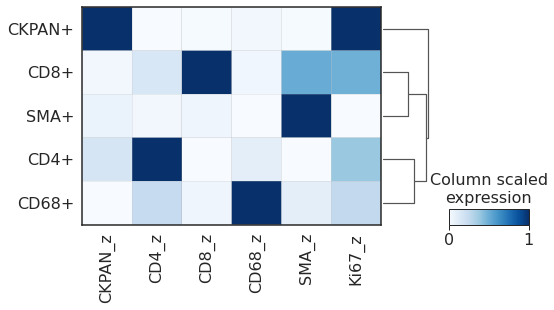

In [ ]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_lineage', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title="Column scaled\nexpression", figsize=(8,4))

In [9]:
def reformat_core_id(name):
    row_number = name.split('-')[0]
    col_number = name.split('-')[1]
    if len(row_number) < 2:
        new_row_number = '0' + str(row_number)
    else:
        new_row_number = str(row_number)
    return new_row_number + '-' + col_number

def reformat_tma_num(name):
    if len(str(name)) < 2:
        return ('0' + name)
    else:
        return name

core_areas = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/core_area_measurements_allcores.csv')

core_areas['TMA'] = core_areas['Image'].apply(lambda x: x.split('_')[1])
core_areas['TMA'] = core_areas['TMA'].apply(lambda x: reformat_tma_num(x))
core_areas['TMA core'] = core_areas['Parent'].apply(lambda x: reformat_core_id(x))
core_areas['core'] = core_areas['TMA'] + '-' + core_areas['TMA core']

core_areas = core_areas[['TMA', 'core', 'Area µm^2']]
core_areas = core_areas.rename(columns={'Area µm^2':'area_mcm2'})
core_areas['area_mm2'] = core_areas['area_mcm2'] / 1000000

# core_areas.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/processed_core_areas.csv')

core_areas

TMA     core  area_mcm2  area_mm2
0     01  01-18-L   768965.7  0.768966
1     01  01-18-K   877477.5  0.877478
2     01  01-18-J   820472.2  0.820472
3     01  01-18-I   944170.4  0.944170
4     01  01-18-H   811185.6  0.811186
...   ..      ...        ...       ...
2659  23  23-02-F  1089135.8  1.089136
2660  23  23-02-E   961314.9  0.961315
2661  23  23-02-C   544235.3  0.544235
2662  23  23-02-B  1064074.5  1.064075
2663  23  23-02-A  1053745.8  1.053746

[2664 rows x 4 columns]

In [10]:
pivot_clusters_frame = pd.get_dummies(clusters_frame, prefix='cluster', columns=['leiden_2.5'])
pivot_clusters_frame = pivot_clusters_frame.groupby(by='core').sum().reset_index()
pivot_clusters_frame

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
0     01-02-A          0          0          0          0          0   
1     01-02-B          0          0          0          0          0   
2     01-02-C          0          0          0          0          0   
3     01-02-D          0          0          0          0          0   
4     01-02-E          0          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2235  23-15-D          0          0          0          0          0   
2236  23-15-G          0          0          0          0          0   
2237  23-15-H          0          0          0          0          0   
2238  23-15-I          0          0          0          0          0   
2239  23-15-J          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_61  cluster_62  \
0             0          0          0          0  ...           1           0   
1             0          0          0          0  ...           0           0   
2             0          0          0          0  ...           0           0   
3             0          0          0          0  ...           0           0   
4             0          0          1          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2235          0          0          0          0  ...           0           0   
2236          0          0          0          0  ...           0           0   
2237          0          0          0          0  ...           0           0   
2238          0          0          0          0  ...           0           1   
2239          0          0          0          0  ...           0           0   

      cluster_63  cluster_64  cluster_65  cluster_66  cluster_67  cluster_68  \
0              0           0           0           0           0           0   
1              0           3           0           0           0           1   
2              0           2           0           0           0           0   
3              0           1           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2235           0           0           0           0           0           1   
2236           0           0           0           0           0           0   
2237           0           0           0           0           0           0   
2238           0           0           0           0           0           0   
2239           0           0           0           0           0           0   

      cluster_69  cluster_70  
0              2           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0  
...          ...         ...  
2235           0           0  
2236           0           0  
2237           0           0  
2238           0           0  
2239           0           0  

[2240 rows x 72 columns]

In [11]:
majority_clusters_frame = pivot_clusters_frame.copy(deep=True)

majority_clusters_frame = majority_clusters_frame[['core']+[col for col in majority_clusters_frame.columns.values[1:] if int(col.split('cluster_')[1]) in leiden_clusters]]
majority_clusters_frame['max'] = majority_clusters_frame.max(numeric_only=True, axis=1)
majority_clusters_frame['sum'] = majority_clusters_frame.iloc[:, :-1].sum(numeric_only=True, axis=1)
majority_clusters_frame

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
0     01-02-A          0          0          0          0          0   
1     01-02-B          0          0          0          0          0   
2     01-02-C          0          0          0          0          0   
3     01-02-D          0          0          0          0          0   
4     01-02-E          0          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2235  23-15-D          0          0          0          0          0   
2236  23-15-G          0          0          0          0          0   
2237  23-15-H          0          0          0          0          0   
2238  23-15-I          0          0          0          0          0   
2239  23-15-J          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_63  cluster_64  \
0             0          0          0          0  ...           0           0   
1             0          0          0          0  ...           0           3   
2             0          0          0          0  ...           0           2   
3             0          0          0          0  ...           0           1   
4             0          0          1          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2235          0          0          0          0  ...           0           0   
2236          0          0          0          0  ...           0           0   
2237          0          0          0          0  ...           0           0   
2238          0          0          0          0  ...           0           0   
2239          0          0          0          0  ...           0           0   

      cluster_65  cluster_66  cluster_67  cluster_68  cluster_69  cluster_70  \
0              0           0           0           0           2           0   
1              0           0           0           1           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2235           0           0           0           1           0           0   
2236           0           0           0           0           0           0   
2237           0           0           0           0           0           0   
2238           0           0           0           0           0           0   
2239           0           0           0           0           0           0   

      max  sum  
0       2    4  
1       3    4  
2       2    4  
3       1    4  
4       3    4  
...   ...  ...  
2235    1    4  
2236    3    4  
2237    1    4  
2238    2    4  
2239    1    2  

[2240 rows x 74 columns]

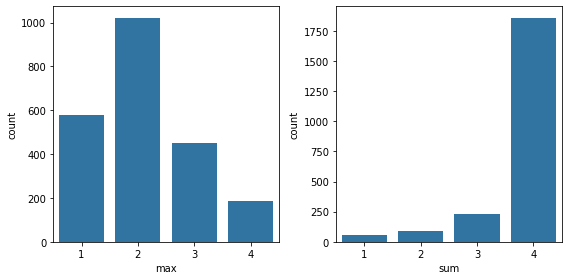

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axs = axs.flatten()

sns.countplot(x='max', data=majority_clusters_frame, ax=axs[0])
sns.countplot(x='sum', data=majority_clusters_frame, ax=axs[1])

plt.tight_layout()

In [27]:
def concat_phenotypes(row, colnames):
    positive_cols = [col for col in colnames if row[col] == 1]
    if len(positive_cols) == 0:
        return 'Negative'
    return '_'.join(['HPC ' + col.split("_")[1] for col in positive_cols])

# May take 'mixed' cases if the epithelial compartment is pure is. if the other HPC is a stromal one
colnames = [c for c in majority_clusters_frame.columns.values if c.startswith('cluster_')]
borderline_cores = majority_clusters_frame.loc[(majority_clusters_frame['max'] == 2)]
borderline_cores['hpc_phenotype'] = borderline_cores.apply(lambda row: concat_phenotypes(row, colnames), axis=1)
borderline_cores

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
0     01-02-A          0          0          0          0          0   
2     01-02-C          0          0          0          0          0   
8     01-03-B          0          0          0          0          0   
10    01-03-E          0          0          0          0          0   
12    01-03-H          0          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2221  23-11-J          0          0          0          0          0   
2229  23-14-D          0          0          0          0          0   
2231  23-14-I          2          0          0          0          0   
2233  23-15-B          0          0          0          0          0   
2238  23-15-I          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_64  cluster_65  \
0             0          0          0          0  ...           0           0   
2             0          0          0          0  ...           2           0   
8             0          0          0          0  ...           0           0   
10            0          0          0          0  ...           0           0   
12            0          0          0          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2221          0          0          0          0  ...           0           0   
2229          0          0          0          0  ...           0           0   
2231          0          0          0          0  ...           0           0   
2233          0          0          0          0  ...           0           0   
2238          0          0          0          0  ...           0           0   

      cluster_66  cluster_67  cluster_68  cluster_69  cluster_70  max  sum  \
0              0           0           0           2           0    2    4   
2              0           0           0           0           0    2    4   
8              0           0           0           1           0    2    4   
10             0           0           0           0           0    2    4   
12             0           0           0           0           0    2    2   
...          ...         ...         ...         ...         ...  ...  ...   
2221           0           0           0           0           0    2    4   
2229           0           0           0           0           0    2    4   
2231           0           0           0           2           0    2    4   
2233           0           0           0           0           0    2    3   
2238           0           0           0           0           0    2    4   

      hpc_phenotype  
0     HPC 48_HPC 61  
2     HPC 27_HPC 31  
8     HPC 46_HPC 69  
10    HPC 30_HPC 32  
12         Negative  
...             ...  
2221  HPC 39_HPC 62  
2229  HPC 31_HPC 40  
2231       Negative  
2233         HPC 23  
2238  HPC 36_HPC 62  

[1023 rows x 75 columns]

In [31]:
def check_companion_phenotype(row, malignant_clusters, stromal_clusters):
    clus1 = int(row['hpc_phenotype'].split("_")[0].split(" ")[1])
    clus2 = int(row['hpc_phenotype'].split("_")[1].split(" ")[1])


    if clus1 in malignant_clusters and clus2 in malignant_clusters:
        return -1
    
    elif clus1 in stromal_clusters and clus2 in malignant_clusters:
        return clus2
    
    elif clus1 in malignant_clusters and clus2 in stromal_clusters:
        return clus1
    
    else:
        return -1

In [32]:
borderline_cores = borderline_cores[borderline_cores['hpc_phenotype'] != 'Negative'] # filter those without hits
borderline_cores['single_phenotype'] = borderline_cores['hpc_phenotype'].apply(lambda x: 0 if '_' in x else 1)
borderline_cores = borderline_cores[borderline_cores['single_phenotype'] == 0]
borderline_cores['malignant_phenotype'] = borderline_cores.apply(lambda row: check_companion_phenotype(row, malignant_clusters, stromal_clusters), axis=1)
borderline_cores

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
0     01-02-A          0          0          0          0          0   
2     01-02-C          0          0          0          0          0   
8     01-03-B          0          0          0          0          0   
10    01-03-E          0          0          0          0          0   
15    01-04-B          0          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2211  23-10-H          0          0          0          0          0   
2215  23-11-D          0          0          0          0          0   
2221  23-11-J          0          0          0          0          0   
2229  23-14-D          0          0          0          0          0   
2238  23-15-I          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_66  cluster_67  \
0             0          0          0          0  ...           0           0   
2             0          0          0          0  ...           0           0   
8             0          0          0          0  ...           0           0   
10            0          0          0          0  ...           0           0   
15            0          0          0          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2211          0          0          0          0  ...           2           0   
2215          0          0          0          0  ...           0           0   
2221          0          0          0          0  ...           0           0   
2229          0          0          0          0  ...           0           0   
2238          0          0          0          0  ...           0           0   

      cluster_68  cluster_69  cluster_70  max  sum  hpc_phenotype  \
0              0           2           0    2    4  HPC 48_HPC 61   
2              0           0           0    2    4  HPC 27_HPC 31   
8              0           1           0    2    4  HPC 46_HPC 69   
10             0           0           0    2    4  HPC 30_HPC 32   
15             2           0           0    2    4  HPC 38_HPC 46   
...          ...         ...         ...  ...  ...            ...   
2211           0           0           0    2    4  HPC 35_HPC 45   
2215           0           0           0    2    4  HPC 31_HPC 52   
2221           0           0           0    2    4  HPC 39_HPC 62   
2229           0           0           0    2    4  HPC 31_HPC 40   
2238           0           0           0    2    4  HPC 36_HPC 62   

      single_phenotype  malignant_phenotype  
0                    0                   -1  
2                    0                   -1  
8                    0                   -1  
10                   0                   30  
15                   0                   -1  
...                ...                  ...  
2211                 0                   -1  
2215                 0                   -1  
2221                 0                   -1  
2229                 0                   -1  
2238                 0                   -1  

[713 rows x 77 columns]

In [37]:
borderline_cores_accept = borderline_cores[borderline_cores['malignant_phenotype'] != -1]
borderline_cores_accept['cluster'] = borderline_cores_accept['malignant_phenotype'].apply(lambda x: 'HPC ' + str(x))
borderline_cores_accept

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
10    01-03-E          0          0          0          0          0   
52    01-10-D          0          0          0          0          0   
58    01-11-B          0          0          0          0          0   
103   01-17-G          0          0          0          1          0   
119   01-18-L          1          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2009  20-15-E          0          0          0          0          0   
2072  21-14-H          0          0          0          0          0   
2081  22-02-C          0          0          0          1          0   
2083  22-02-F          0          0          0          0          0   
2107  22-06-C          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_67  cluster_68  \
10            0          0          0          0  ...           0           0   
52            0          0          0          0  ...           0           0   
58            0          0          0          0  ...           0           0   
103           0          0          0          0  ...           0           0   
119           0          0          0          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2009          0          0          0          0  ...           0           0   
2072          0          0          0          0  ...           0           0   
2081          0          0          0          0  ...           0           0   
2083          0          0          0          0  ...           0           0   
2107          0          0          0          0  ...           0           0   

      cluster_69  cluster_70  max  sum  hpc_phenotype  single_phenotype  \
10             0           0    2    4  HPC 30_HPC 32                 0   
52             2           0    2    4  HPC 50_HPC 60                 0   
58             0           0    2    4  HPC 10_HPC 11                 0   
103            0           0    2    4   HPC 3_HPC 31                 0   
119            2           0    2    4   HPC 0_HPC 16                 0   
...          ...         ...  ...  ...            ...               ...   
2009           0           0    2    4  HPC 25_HPC 48                 0   
2072           0           0    2    4  HPC 56_HPC 64                 0   
2081           0           0    2    4   HPC 3_HPC 27                 0   
2083           0           0    2    4  HPC 11_HPC 32                 0   
2107           0           0    2    4  HPC 16_HPC 50                 0   

      malignant_phenotype  cluster  
10                     30   HPC 30  
52                     50   HPC 50  
58                     11   HPC 11  
103                    31   HPC 31  
119                     0    HPC 0  
...                   ...      ...  
2009                   48   HPC 48  
2072                   64   HPC 64  
2081                   27   HPC 27  
2083                   11   HPC 11  
2107                   50   HPC 50  

[99 rows x 78 columns]

In [38]:
cluster_pure_cores = majority_clusters_frame.loc[(majority_clusters_frame['max'] == 4) | (majority_clusters_frame['max'] == 3)]
cluster_pure_cores['cluster'] = cluster_pure_cores.iloc[:, :-2].idxmax(numeric_only=True, axis=1)
cluster_pure_cores['cluster'] = cluster_pure_cores['cluster'].apply(lambda x: 'HPC ' + x.split("_")[1])
cluster_pure_cores['cluster'].value_counts()

HPC 52    71
HPC 11    45
HPC 46    42
HPC 44    31
HPC 48    31
HPC 64    28
HPC 67    28
HPC 50    25
HPC 68    24
HPC 17    22
HPC 0     21
HPC 41    20
HPC 35    19
HPC 30    18
HPC 21    15
HPC 27    14
HPC 13    14
HPC 34    14
HPC 28    13
HPC 31    12
HPC 54    12
HPC 47    12
HPC 69     9
HPC 56     8
HPC 33     7
HPC 16     6
HPC 58     5
HPC 40     5
HPC 70     4
HPC 61     4
HPC 43     4
HPC 32     4
HPC 15     4
HPC 2      3
HPC 60     3
HPC 12     3
HPC 22     3
HPC 1      3
HPC 6      3
HPC 37     3
HPC 38     2
HPC 8      2
HPC 24     2
HPC 10     2
HPC 66     2
HPC 55     2
HPC 45     2
HPC 5      2
HPC 53     2
HPC 62     2
HPC 57     2
HPC 59     1
HPC 65     1
HPC 25     1
HPC 51     1
Name: cluster, dtype: int64

In [43]:
cluster_pure_cores.shape

(638, 75)

In [42]:
joint_pure_cores = pd.concat([cluster_pure_cores, borderline_cores_accept.drop(labels=['hpc_phenotype', 'single_phenotype', 'malignant_phenotype'], axis=1)])
joint_pure_cores

core  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
1     01-02-B          0          0          0          0          0   
4     01-02-E          0          0          0          0          0   
7     01-02-K          0          0          0          0          0   
14    01-04-A          0          0          0          0          0   
20    01-04-K          0          0          0          0          0   
...       ...        ...        ...        ...        ...        ...   
2009  20-15-E          0          0          0          0          0   
2072  21-14-H          0          0          0          0          0   
2081  22-02-C          0          0          0          1          0   
2083  22-02-F          0          0          0          0          0   
2107  22-06-C          0          0          0          0          0   

      cluster_5  cluster_6  cluster_7  cluster_8  ...  cluster_64  cluster_65  \
1             0          0          0          0  ...           3           0   
4             0          0          1          0  ...           0           0   
7             0          0          0          4  ...           0           0   
14            0          0          0          0  ...           0           0   
20            0          4          0          0  ...           0           0   
...         ...        ...        ...        ...  ...         ...         ...   
2009          0          0          0          0  ...           0           0   
2072          0          0          0          0  ...           1           0   
2081          0          0          0          0  ...           2           0   
2083          0          0          0          0  ...           0           0   
2107          0          0          0          0  ...           0           0   

      cluster_66  cluster_67  cluster_68  cluster_69  cluster_70  max  sum  \
1              0           0           1           0           0    3    4   
4              0           0           0           0           0    3    4   
7              0           0           0           0           0    4    4   
14             0           0           0           0           0    3    4   
20             0           0           0           0           0    4    4   
...          ...         ...         ...         ...         ...  ...  ...   
2009           0           0           0           0           0    2    4   
2072           0           0           0           0           0    2    4   
2081           0           0           0           0           0    2    4   
2083           0           0           0           0           0    2    4   
2107           0           0           0           0           0    2    4   

      cluster  
1      HPC 64  
4      HPC 24  
7       HPC 8  
14     HPC 21  
20      HPC 6  
...       ...  
2009   HPC 48  
2072   HPC 64  
2081   HPC 27  
2083   HPC 11  
2107   HPC 50  

[737 rows x 75 columns]

In [44]:
pure_cores_densities = pd.DataFrame()

for i, core in enumerate(joint_pure_cores['core'].values):
    phenotypes, counts = np.unique(adata.obs[adata.obs['core'] == core]['cell_lineage'].values, return_counts=True)
    pure_cores_densities.loc[i, 'core'] = core
    for j, _ in enumerate(phenotypes):
        pure_cores_densities.loc[i, phenotypes[j]] = counts[j]

pure_cores_densities = pure_cores_densities.fillna(0)

pure_cores_densities

core    CD4+  CD68+    CD8+  CKPAN+  Negative    SMA+
0    01-02-B  1169.0  324.0   883.0  1765.0    1816.0   786.0
1    01-02-E     0.0    0.0     0.0     0.0       0.0     0.0
2    01-02-K   175.0  129.0  1274.0   516.0    1525.0  1153.0
3    01-04-A   479.0  416.0   189.0  1706.0    1104.0   990.0
4    01-04-K   187.0  140.0  1093.0   200.0    1175.0  1217.0
..       ...     ...    ...     ...     ...       ...     ...
732  20-15-E  2904.0  598.0   521.0  2020.0    3688.0   837.0
733  21-14-H   890.0  279.0   404.0   926.0    1224.0   973.0
734  22-02-C  1049.0  721.0   404.0   969.0    1444.0  3058.0
735  22-02-F  1651.0  859.0   585.0  2880.0    2250.0   467.0
736  22-06-C  1823.0  878.0  1399.0  2988.0    1569.0  1015.0

[737 rows x 7 columns]

In [45]:
pure_cores_densities.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/pure_cores_cell_counts_all.csv')

In [46]:
pure_cores_densities = pure_cores_densities.merge(core_areas[['core', 'area_mm2']], on='core')
pure_cores_densities

core    CD4+  CD68+    CD8+  CKPAN+  Negative    SMA+  area_mm2
0    01-02-B  1169.0  324.0   883.0  1765.0    1816.0   786.0  0.863007
1    01-02-E     0.0    0.0     0.0     0.0       0.0     0.0  0.775773
2    01-02-K   175.0  129.0  1274.0   516.0    1525.0  1153.0  0.773031
3    01-04-A   479.0  416.0   189.0  1706.0    1104.0   990.0  0.675307
4    01-04-K   187.0  140.0  1093.0   200.0    1175.0  1217.0  0.808978
..       ...     ...    ...     ...     ...       ...     ...       ...
722  20-15-E  2904.0  598.0   521.0  2020.0    3688.0   837.0  1.002336
723  21-14-H   890.0  279.0   404.0   926.0    1224.0   973.0  0.840874
724  22-02-C  1049.0  721.0   404.0   969.0    1444.0  3058.0  1.026608
725  22-02-F  1651.0  859.0   585.0  2880.0    2250.0   467.0  1.074565
726  22-06-C  1823.0  878.0  1399.0  2988.0    1569.0  1015.0  0.988457

[727 rows x 8 columns]

In [53]:
norm_pure_cores_densities = pure_cores_densities.copy(deep=True)

for phenotype in adata.obs['cell_lineage'].unique():
    norm_pure_cores_densities[f'{phenotype.split("+")[0]}_mm2'] = norm_pure_cores_densities[phenotype] / norm_pure_cores_densities['area_mm2']

norm_pure_cores_densities

core    CD4+  CD68+    CD8+  CKPAN+  Negative    SMA+  area_mm2  \
0    01-02-B  1169.0  324.0   883.0  1765.0    1816.0   786.0  0.863007   
1    01-02-E     0.0    0.0     0.0     0.0       0.0     0.0  0.775773   
2    01-02-K   175.0  129.0  1274.0   516.0    1525.0  1153.0  0.773031   
3    01-04-A   479.0  416.0   189.0  1706.0    1104.0   990.0  0.675307   
4    01-04-K   187.0  140.0  1093.0   200.0    1175.0  1217.0  0.808978   
..       ...     ...    ...     ...     ...       ...     ...       ...   
722  20-15-E  2904.0  598.0   521.0  2020.0    3688.0   837.0  1.002336   
723  21-14-H   890.0  279.0   404.0   926.0    1224.0   973.0  0.840874   
724  22-02-C  1049.0  721.0   404.0   969.0    1444.0  3058.0  1.026608   
725  22-02-F  1651.0  859.0   585.0  2880.0    2250.0   467.0  1.074565   
726  22-06-C  1823.0  878.0  1399.0  2988.0    1569.0  1015.0  0.988457   

       CKPAN_mm2      SMA_mm2  Negative_mm2      CD4_mm2    CD68_mm2  \
0    2045.174368   910.768869   2104.270058  1354.565913  375.431442   
1       0.000000     0.000000      0.000000     0.000000    0.000000   
2     667.502252  1491.531195   1972.753748   226.381578  166.875563   
3    2526.258428  1465.999908   1634.812019   709.307026  616.016123   
4     247.225634  1504.367983   1452.450599   231.155968  173.057944   
..           ...          ...           ...          ...         ...   
722  2015.291674   835.049075   3679.403809  2897.231199  596.606149   
723  1101.234620  1157.128817   1455.627618  1058.422043  331.797472   
724   943.884921  2978.741062   1406.573608  1021.811437  702.312723   
725  2680.154544   434.594504   2093.870738  1536.435817  799.393317   
726  3022.894174  1026.853275   1587.322945  1844.289183  888.253375   

         CD8_mm2  
0    1023.166553  
1       0.000000  
2    1648.057885  
3     279.872710  
4    1351.088089  
..           ...  
722   519.785625  
723   480.452253  
724   393.528904  
725   544.406392  
726  1415.337667  

[727 rows x 14 columns]

In [54]:
norm_pure_cores_densities = norm_pure_cores_densities.drop(columns=[col for col in adata.obs['cell_lineage'].unique()]+['area_mm2'])
norm_pure_cores_densities = norm_pure_cores_densities.merge(joint_pure_cores[['core', 'cluster']])
# norm_pure_cores_densities['predom_cluster_num'] = norm_pure_cores_densities['cluster'].apply(lambda x: x.split('_')[1])
# norm_pure_cores_densities = norm_pure_cores_densities.merge(cluster_topography[['cluster', 'tier_1', 'tier_2', 'tier_3']], left_on='predom_cluster_num', right_on='cluster')
# norm_pure_cores_densities = norm_pure_cores_densities.drop(labels=['predom_cluster_num'], axis=1)
norm_pure_cores_densities

core    CKPAN_mm2      SMA_mm2  Negative_mm2      CD4_mm2    CD68_mm2  \
0    01-02-B  2045.174368   910.768869   2104.270058  1354.565913  375.431442   
1    01-02-E     0.000000     0.000000      0.000000     0.000000    0.000000   
2    01-02-K   667.502252  1491.531195   1972.753748   226.381578  166.875563   
3    01-04-A  2526.258428  1465.999908   1634.812019   709.307026  616.016123   
4    01-04-K   247.225634  1504.367983   1452.450599   231.155968  173.057944   
..       ...          ...          ...           ...          ...         ...   
722  20-15-E  2015.291674   835.049075   3679.403809  2897.231199  596.606149   
723  21-14-H  1101.234620  1157.128817   1455.627618  1058.422043  331.797472   
724  22-02-C   943.884921  2978.741062   1406.573608  1021.811437  702.312723   
725  22-02-F  2680.154544   434.594504   2093.870738  1536.435817  799.393317   
726  22-06-C  3022.894174  1026.853275   1587.322945  1844.289183  888.253375   

         CD8_mm2 cluster  
0    1023.166553  HPC 64  
1       0.000000  HPC 24  
2    1648.057885   HPC 8  
3     279.872710  HPC 21  
4    1351.088089   HPC 6  
..           ...     ...  
722   519.785625  HPC 48  
723   480.452253  HPC 64  
724   393.528904  HPC 27  
725   544.406392  HPC 11  
726  1415.337667  HPC 50  

[727 rows x 8 columns]

In [55]:
norm_pure_cores_densities.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/pure_cores_densities_with_annotations.csv')

In [52]:
adata.write_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/2410_Bioclavis_filtered_negative_with_annotations.h5ad')

In [101]:
# Spatial correlation analysis -- makes a spatial heatmap, positive correlation of spatial densities of two cell types suggests colocalisation
# First, need to take into account edge effect, by excluding cells a certain distance from the periphery

# This considers the neighbours of each cell in a specified radius, then calculates a correlation between the two phenotypes in the neighbourhood across the core

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def create_buffer(coords, buffer_distance):
    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    
    is_interior = (
        (coords[:, 0] > min_x + buffer_distance) & 
        (coords[:, 0] < max_x - buffer_distance) & 
        (coords[:, 1] > min_y + buffer_distance) & 
        (coords[:, 1] < max_y - buffer_distance)
    )
    
    return is_interior

def plot_spatial_densities(cell_type1, cell_type2, density1, density2, mask1, mask2, ax):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
    # ax.scatter(density1[mask1], density2[mask2])
    ax.scatter(density1, density2, alpha=0.5)
    ax.set_xlabel(cell_type1)
    ax.set_ylabel(cell_type2)

def spatial_correlation(coords, cell_types, cell_type1, cell_type2, radius, ax):
    distances = squareform(pdist(coords))
    
    mask1 = cell_types == cell_type1
    mask2 = cell_types == cell_type2
    
    density1 = np.sum((distances < radius) & mask1[np.newaxis, :], axis=1)
    density2 = np.sum((distances < radius) & mask2[np.newaxis, :], axis=1)
    
    corr, p_val = spearmanr(density1, density2)
    print(density1.shape)
    print(density2.shape)

    plot_spatial_densities(cell_type1, cell_type2, density1, density2, mask1, mask2, ax)

    return corr, p_val

def cell_spatial_correlation(core_df, x_col, y_col, phenotype_col, buffer_distance, radius):
    coordinates = core_df[[x_col, y_col]].values
    phenotypes = core_df[phenotype_col].values
    interior_mask = create_buffer(coordinates, buffer_distance)
    interior_coordinates = coordinates[interior_mask]
    interior_phenotypes = phenotypes[interior_mask]

    tree = KDTree(data=interior_coordinates)
    neighbours = tree.query_ball_point(interior_coordinates, r=radius, workers=12)

    for i, neighbours_list in enumerate(neighbours):
        neighbours_list = neighbours_list.remove(i) # remove self from the list of neighbours

    neighbours_phenotypes = [interior_phenotypes[neighbours[i]] for i in range(len(neighbours))]

    neighbours_summary_list = list()

    for i, neighbours in enumerate(neighbours_phenotypes):
        u, c = np.unique(neighbours, return_counts=True)
        o = interior_phenotypes[i]
        result_dict = {'phenotype':o}
        result_dict.update(dict(zip(u, c)))
        neighbours_summary_list.append(result_dict)

    neighbours_df = pd.DataFrame.from_dict(neighbours_summary_list, orient='columns')
    neighbours_df = neighbours_df.fillna(0)
    neighbours_df = neighbours_df.drop(columns='Negative')
    neighbours_df = neighbours_df[neighbours_df['phenotype'] != 'Negative']

    return neighbours_df

core = '03-03-K'
core_df = adata.obs[adata.obs['core'] == core]
x_col = 'CellX'
y_col = 'CellY'
phenotype_col = 'cell_lineage'
buffer_distance = 10
radius = 25

neighbours = cell_spatial_correlation(core_df, x_col, y_col, phenotype_col, buffer_distance, radius)

neighbours


# cell_results_frame = dict()
# tile_size = 100
# buffer_distance = 50

# for cluster in norm_pure_cores_densities['predom_cluster_num'].unique():
#     core_ids = norm_pure_cores_densities.loc[(norm_pure_cores_densities['predom_cluster_num'] == cluster)]['core'].values
#     cluster_subset = adata.obs[adata.obs['core'].isin(core_ids)]
#     cluster_list = list()
#     for unique_core in cluster_subset['core'].unique():
#         core_subset = cluster_subset[cluster_subset['core'] == unique_core]
#         core_df = calculate_spatial_correlation(core_subset, tile_size, buffer_distance)
#         core_df = core_df.drop(columns=['x', 'y', 'Negative'])
#         cluster_list.append(core_df)
#     cluster_df = pd.concat(cluster_list)
#     cell_results_frame[cluster] = cluster_df

# coords = adata.obs[adata.obs['core'] == core][['CellX', 'CellY']].values
# cell_types = adata.obs[adata.obs['core'] == core]['cell_lineage'].values

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# axs = axs.flatten()

# buffer_distance = 250  # Adjust based on your data scale
# interior_mask = create_buffer(coords, buffer_distance)
# interior_coords = coords[interior_mask]
# interior_cell_types = cell_types[interior_mask]

# radius = 100

# corr_ckpan_cd8, p_val1 = spatial_correlation(interior_coords, interior_cell_types, 'CKPAN+', 'CD8+', radius=radius, ax=axs[0])
# corr_cd8_sma, p_val2 = spatial_correlation(interior_coords, interior_cell_types, 'CD8+', 'SMA+', radius=radius, ax=axs[1])

# print(f"Spatial correlation between CKPAN+ and CD8+: {corr_ckpan_cd8}, p = {p_val1:.2f}")
# print(f"Spatial correlation between CD8+ and SMA+: {corr_cd8_sma}, p = {p_val2:.2f}")

phenotype  CKPAN+  CD4+  SMA+  CD68+  CD8+
0       CKPAN+     5.0   0.0   0.0    0.0   0.0
1       CKPAN+     4.0   0.0   0.0    0.0   0.0
2       CKPAN+     6.0   0.0   0.0    0.0   0.0
3       CKPAN+     7.0   0.0   0.0    0.0   0.0
4       CKPAN+     6.0   0.0   0.0    0.0   0.0
...        ...     ...   ...   ...    ...   ...
4666    CKPAN+     1.0   0.0   0.0    0.0   0.0
4667    CKPAN+     1.0   0.0   1.0    0.0   0.0
4670      SMA+     2.0   0.0   1.0    1.0   1.0
4671    CKPAN+     1.0   0.0   0.0    0.0   0.0
4672    CKPAN+     2.0   0.0   1.0    0.0   1.0

[3305 rows x 6 columns]

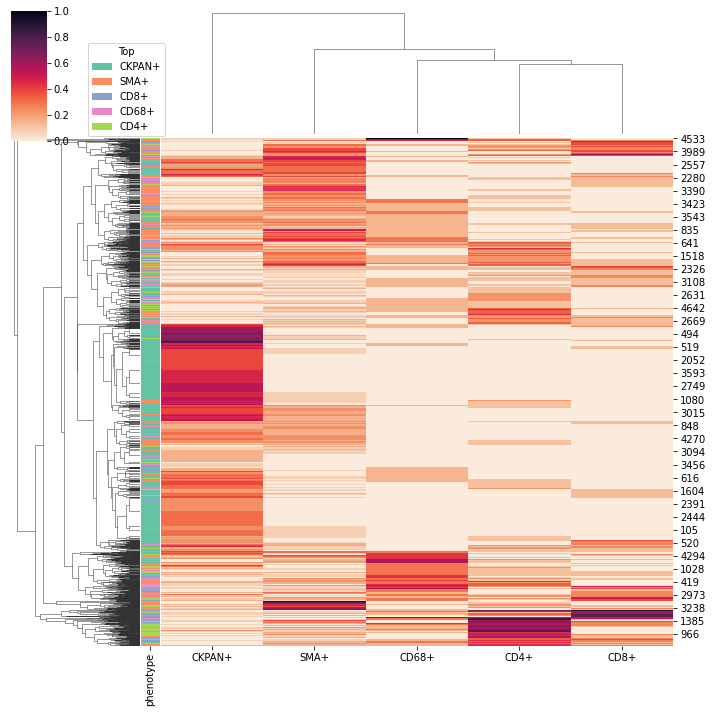

In [102]:
# phenotypes_palette = sns.husl_palette(len(neighbours['phenotype'].unique()))
phenotypes_palette = sns.color_palette(palette='Set2', n_colors=len(neighbours['phenotype'].unique()))
palette_dict = dict(zip(neighbours['phenotype'].unique(), phenotypes_palette))
mapped_colors = neighbours['phenotype'].map(palette_dict)

sns.clustermap(neighbours.iloc[:, 1:], standard_scale=1, cmap='rocket_r', row_colors=mapped_colors)
legend_elements_1 = [Patch(facecolor=color, label=label) for label, color in palette_dict.items()]
plt.legend(handles=legend_elements_1, title='Top', loc='lower left', bbox_to_anchor=[2.0, 0.0, 1.0, 0.0])

In [103]:
neighbours_dict = dict()

for cluster in norm_pure_cores_densities['predom_cluster_num'].unique():
    core_ids = norm_pure_cores_densities.loc[(norm_pure_cores_densities['predom_cluster_num'] == cluster)]['core'].values
    cluster_subset = adata.obs[adata.obs['core'].isin(core_ids)]
    cluster_list = list()
    for unique_core in cluster_subset['core'].unique():
        core_subset = cluster_subset[cluster_subset['core'] == unique_core]
        core_neighbours_df = cell_spatial_correlation(core_subset, 'CellX', 'CellY', 'cell_lineage', buffer_distance=10, radius=25)
        cluster_list.append(core_neighbours_df)
    cluster_df = pd.concat(cluster_list)
    neighbours_dict[cluster] = cluster_df

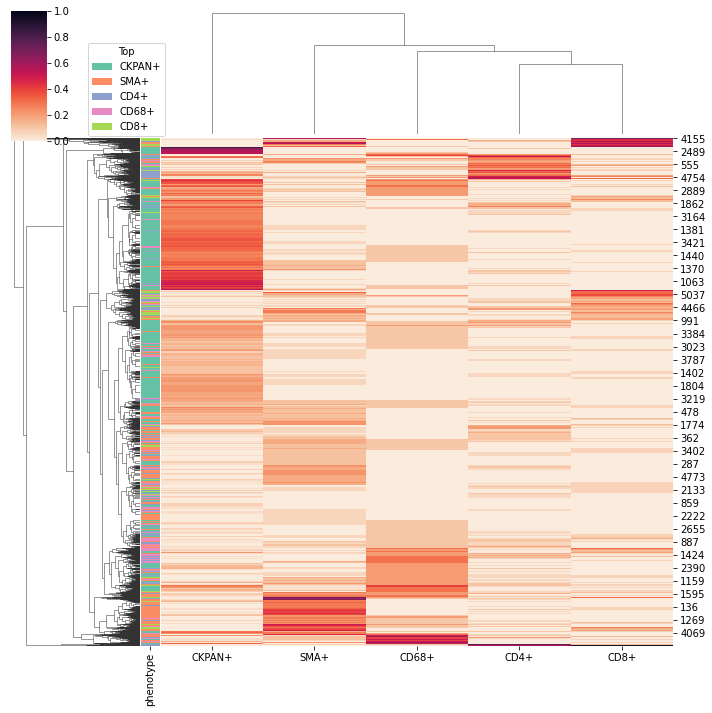

In [107]:
neighbours = neighbours_dict['27']

phenotypes_palette = sns.color_palette(palette='Set2', n_colors=len(neighbours['phenotype'].unique()))
palette_dict = dict(zip(neighbours['phenotype'].unique(), phenotypes_palette))
mapped_colors = neighbours['phenotype'].map(palette_dict)

sns.clustermap(neighbours.iloc[:, 1:], standard_scale=1, cmap='rocket_r', row_colors=mapped_colors)
legend_elements_1 = [Patch(facecolor=color, label=label) for label, color in palette_dict.items()]
plt.legend(handles=legend_elements_1, title='Top', loc='lower left', bbox_to_anchor=[2.0, 0.0, 1.0, 0.0])

In [111]:
neighbours[neighbours['phenotype'] == 'CD8+']

phenotype  CD4+  CKPAN+  SMA+  CD68+  CD8+
53        CD8+   1.0     8.0   2.0    2.0   2.0
72        CD8+   1.0     6.0   2.0    1.0   2.0
74        CD8+   0.0    10.0   2.0    1.0   0.0
80        CD8+   0.0     6.0   1.0    0.0   2.0
128       CD8+   2.0     1.0   4.0    1.0   0.0
...        ...   ...     ...   ...    ...   ...
3306      CD8+   0.0     2.0   0.0    1.0   0.0
3320      CD8+   0.0     2.0   2.0    1.0   0.0
3379      CD8+   0.0     0.0   2.0    0.0   0.0
3426      CD8+   0.0     4.0   0.0    2.0   0.0
3449      CD8+   0.0     3.0   0.0    0.0   0.0

[4278 rows x 6 columns]

In [26]:
norm_pure_cores_densities[norm_pure_cores_densities['predom_cluster_num'] == '31']

core    CKPAN_mm2      SMA_mm2      CD4_mm2    CD68_mm2      CD8_mm2  \
352  02-04-G   804.965356  1342.314109  1257.692258  665.339302   607.161780   
353  03-03-K  1566.867338   885.343739   463.903134  329.084603   296.176143   
354  03-04-K  1572.173541   715.075774   574.046941  552.197403   828.296105   
355  03-16-D  3002.587500  1125.294054   607.280084  201.525017   637.035456   
356  05-03-H  2288.364259   225.487600   855.066840  507.905238   152.929709   
357  05-12-D  2850.721347   877.327921  1094.876714  682.366161   382.790773   
358  06-04-D  2804.337947   400.619707    93.783748  290.525741   118.249074   
359  07-09-I  1429.187870   841.216897   363.352848  803.780543  1096.664960   
360  12-06-J  2462.464276   431.144921   140.549446  306.739669    55.080188   
361  20-13-B  2453.519857   695.728341  1012.808071  757.297221   382.753202   
362  20-15-D  3438.703532   899.547404   528.943052  305.203583   111.296044   
363  21-07-I  1994.444451   776.838731   659.580055  416.687082   683.659962   
364  23-05-J  3355.673625   225.704981  1013.743311  496.743868   323.124652   

      cluster_x predom_cluster_num cluster_y     tier_1           tier_2  \
352  cluster_31                 31        31  malignant  pattern-forming   
353  cluster_31                 31        31  malignant  pattern-forming   
354  cluster_31                 31        31  malignant  pattern-forming   
355  cluster_31                 31        31  malignant  pattern-forming   
356  cluster_31                 31        31  malignant  pattern-forming   
357  cluster_31                 31        31  malignant  pattern-forming   
358  cluster_31                 31        31  malignant  pattern-forming   
359  cluster_31                 31        31  malignant  pattern-forming   
360  cluster_31                 31        31  malignant  pattern-forming   
361  cluster_31                 31        31  malignant  pattern-forming   
362  cluster_31                 31        31  malignant  pattern-forming   
363  cluster_31                 31        31  malignant  pattern-forming   
364  cluster_31                 31        31  malignant  pattern-forming   

     tier_3  
352  acinar  
353  acinar  
354  acinar  
355  acinar  
356  acinar  
357  acinar  
358  acinar  
359  acinar  
360  acinar  
361  acinar  
362  acinar  
363  acinar  
364  acinar

<Axes: xlabel='CellX', ylabel='CellY'>

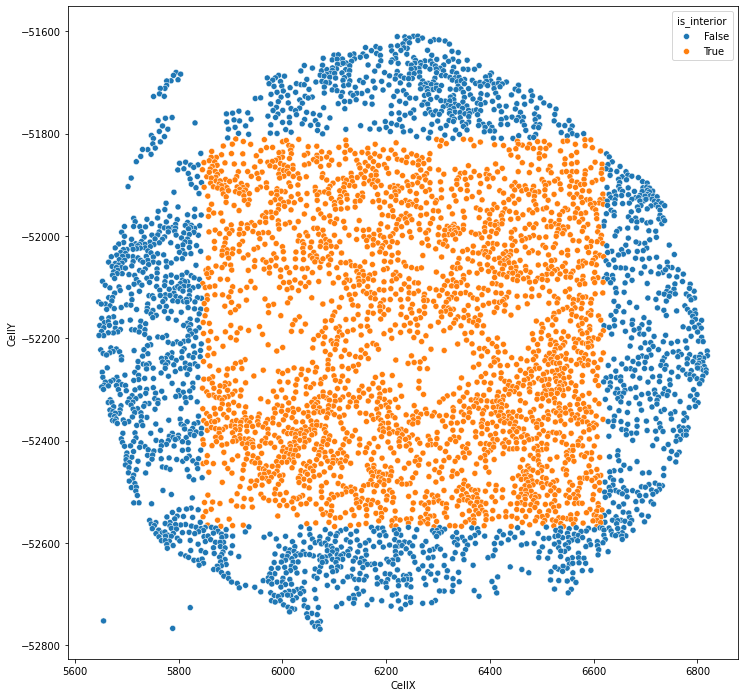

In [27]:
core_df = adata.obs[adata.obs['core'] == core]

def create_buffer_df(df, x_col, y_col, buffer_distance):
    min_x, max_x = df[x_col].min(), df[x_col].max()
    min_y, max_y = df[y_col].min(), df[y_col].max()
    
    is_interior = (
        (df[x_col] > min_x + buffer_distance) & 
        (df[x_col] < max_x - buffer_distance) & 
        (df[y_col] > min_y + buffer_distance) & 
        (df[y_col] < max_y - buffer_distance)
    )
    
    return is_interior

is_interior = create_buffer_df(core_df, 'CellX', 'CellY', 200)
core_df['is_interior'] = is_interior

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='CellX', y='CellY', hue='is_interior', data=core_df, ax=ax)
# sns.scatterplot(x='CellX', y='CellY', hue='cell_lineage', data=buffered_core_df, size=1, ax=ax)

In [28]:
# An alternative approach is tessellation -- non-overlapping tiles -- in which we compute densities and correlate
# We first filter cells at the edge as before and pass the interior coordinates to the function

def create_tessellation(interior_coords, tile_size):
    min_x, min_y = interior_coords.min(axis=0)
    max_x, max_y = interior_coords.max(axis=0)

    n_tiles_x = int((max_x - min_x) // tile_size)
    n_tiles_y = int((max_y - min_y) // tile_size)

    tile_centroids = np.zeros((n_tiles_x * n_tiles_y, 2))

    for i in range(n_tiles_x):
        tile_x = min_x + (i + 0.5) * tile_size
        for j in range(n_tiles_y):
            tile_y = min_y + (j + 0.5) * tile_size
            tile_centroids[i * n_tiles_y + j] = [tile_x, tile_y]
    
    return tile_centroids

core = '03-03-K'

coords = adata.obs[adata.obs['core'] == core][['CellX', 'CellY']].values
cell_types = adata.obs[adata.obs['core'] == core]['cell_lineage'].values
core_df = adata.obs[adata.obs['core'] == core]

buffer_distance = 200  
tile_size = 200

interior_mask = create_buffer(coords, buffer_distance)
interior_coords = coords[interior_mask]
interior_cell_types = cell_types[interior_mask]

tile_centroids = create_tessellation(interior_coords, tile_size=tile_size)

In [29]:
tile_centroids

array([[  5945.70031841, -52468.45063987],
       [  5945.70031841, -52268.45063987],
       [  5945.70031841, -52068.45063987],
       [  6145.70031841, -52468.45063987],
       [  6145.70031841, -52268.45063987],
       [  6145.70031841, -52068.45063987],
       [  6345.70031841, -52468.45063987],
       [  6345.70031841, -52268.45063987],
       [  6345.70031841, -52068.45063987]])

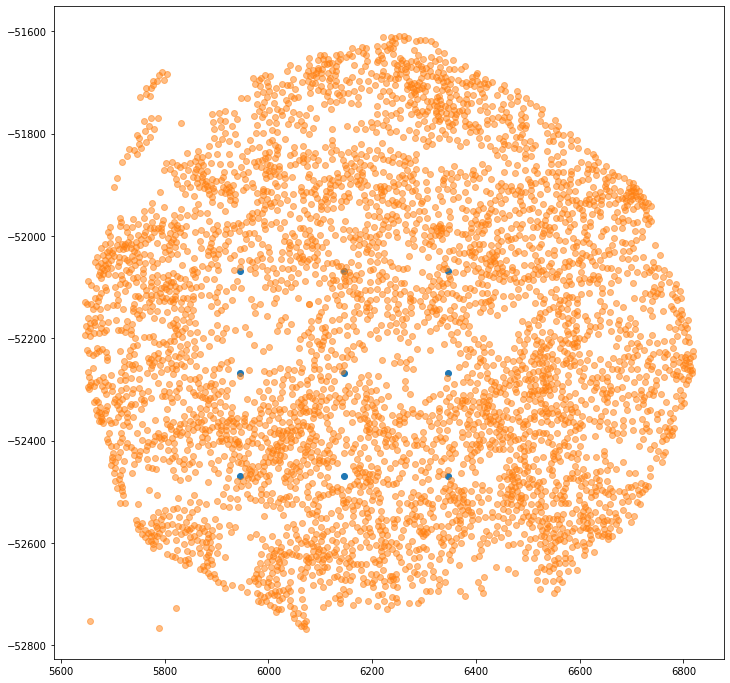

In [30]:
plt.figure(figsize=(12,12))
plt.scatter(tile_centroids[:, 0], tile_centroids[:, 1])
plt.scatter(core_df['CellX'], core_df['CellY'], alpha=0.5)

In [32]:
from scipy.spatial.distance import cdist 

def calculate_spatial_correlation(core_df, tile_size, buffer_distance):
    coordinates = core_df[['CellX', 'CellY']].values
    phenotypes = core_df['cell_lineage'].values

    interior_mask = create_buffer(coordinates, buffer_distance)
    interior_coordinates = coordinates[interior_mask]
    interior_phenotypes = phenotypes[interior_mask]

    tile_centroids = create_tessellation(interior_coordinates, tile_size)

    core_cell_counts = list()

    for centroid in tile_centroids:
        distances = cdist([centroid], core_df[['CellX', 'CellY']].values).flatten()
        cells_in_radius = core_df[distances <= (tile_size / 2)]
        counts = cells_in_radius['cell_lineage'].value_counts().to_dict()
        tile_info = {'x': centroid[0], 'y':centroid[1], **counts}
        core_cell_counts.append(tile_info)
    
    df = pd.DataFrame(core_cell_counts)
    return df

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(spearmanr(tmp[r], tmp[c])[1], 4)
    return pvalues

df = calculate_spatial_correlation(core_df, 100, 200)
df = df.drop(columns=['x', 'y', 'Negative'])


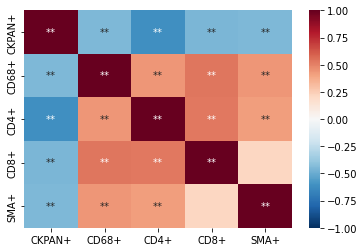

In [34]:
def correlation_matrix(df, method='spearman', ax=None):
    p_vals = calculate_pvalues(df)
    significance_mask = p_vals < 0.05
    annot_text = p_vals.applymap('{:.4f}'.format)
    annot_text = annot_text.mask(p_vals < 0.05, '*')
    annot_text = annot_text.mask(p_vals < 0.01, '**')
    annot_text = annot_text.mask(p_vals < 0.001, '***')
    annot_text = annot_text.mask(~significance_mask, ' ')
    sns.heatmap(df.corr(method=method), vmax=1, vmin=-1, cmap='RdBu_r', annot=annot_text, fmt='.2s')

correlation_matrix(df=df)

In [35]:
## Repeat the exercise for a whole cluster
## Will have to process each core individually then concatenate dataframes

np.sort(norm_pure_cores_densities['core'].values)

array(['01-02-B', '01-04-A', '01-05-B', '01-05-C', '01-06-B', '01-06-H',
       '01-07-G', '01-10-F', '01-11-D', '01-11-F', '01-11-K', '01-12-A',
       '01-12-G', '01-13-I', '01-14-C', '01-16-A', '01-16-K', '01-17-D',
       '02-02-D', '02-03-H', '02-03-I', '02-04-B', '02-04-G', '02-05-E',
       '02-05-F', '02-05-J', '02-06-C', '02-07-B', '02-07-C', '02-09-E',
       '02-10-A', '02-10-J', '02-11-H', '02-11-I', '02-12-H', '02-13-D',
       '02-13-E', '02-13-F', '02-13-I', '02-14-H', '02-14-K', '02-16-F',
       '02-16-G', '02-16-H', '02-16-I', '02-16-J', '02-17-H', '02-17-J',
       '03-02-G', '03-02-H', '03-02-J', '03-03-B', '03-03-F', '03-03-G',
       '03-03-K', '03-03-L', '03-04-E', '03-04-H', '03-04-I', '03-04-K',
       '03-04-L', '03-05-A', '03-05-G', '03-06-L', '03-07-F', '03-09-G',
       '03-09-J', '03-10-G', '03-10-J', '03-11-E', '03-11-G', '03-11-H',
       '03-12-E', '03-12-F', '03-12-G', '03-13-G', '03-13-K', '03-13-L',
       '03-14-F', '03-14-J', '03-14-K', '03-16-A', 

In [115]:
results_frames = dict()

tile_size = 50
buffer_distance = 25

for cluster in norm_pure_cores_densities['predom_cluster_num'].unique():
    core_ids = norm_pure_cores_densities.loc[(norm_pure_cores_densities['predom_cluster_num'] == cluster)]['core'].values
    cluster_subset = adata.obs[adata.obs['core'].isin(core_ids)]
    cluster_list = list()
    for unique_core in cluster_subset['core'].unique():
        core_subset = cluster_subset[cluster_subset['core'] == unique_core]
        core_df = calculate_spatial_correlation(core_subset, tile_size, buffer_distance)
        core_df = core_df.drop(columns=['x', 'y', 'Negative'])
        cluster_list.append(core_df)
    cluster_df = pd.concat(cluster_list)
    results_frames[cluster] = cluster_df
